In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Loading and Preprocessing Image Data

In [2]:
dataset_path = "/kaggle/input/skin-disease-image-dataset-balanced/Split_smol"

In [3]:
batch_size = 32
img_size = (128, 128)

train_data_path = f"{dataset_path}/train"
val_data_path = f"{dataset_path}/val"

train_data = image_dataset_from_directory(train_data_path, 
                                          batch_size=batch_size, 
                                          image_size=img_size,
                                          label_mode='categorical',
                                         )

temp_val_data = image_dataset_from_directory(val_data_path, 
                                             batch_size=batch_size, 
                                             image_size=img_size,
                                             label_mode='categorical',
                                            )

test_data = temp_val_data.take(1)
val_data = temp_val_data.skip(1)

Found 1849 files belonging to 8 classes.
Found 459 files belonging to 8 classes.


In [4]:
print(f"Train data ~ {len(train_data)*32}")
print(f"Val data ~ {len(val_data)*32}")
print(f"Test data ~ {len(test_data)*32}")

Train data ~ 1856
Val data ~ 448
Test data ~ 32


In [5]:
class_names = train_data.class_names
num_classes = len(class_names)

print(class_names)
print(num_classes)

['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
8


## Visualizing images

In [6]:
import matplotlib.pyplot as plt

In [7]:
data_iter = train_data.as_numpy_iterator()

In [8]:
batch = data_iter.next()

In [9]:
print(batch[0])
print(batch[1])

[[[[ 25.789062   24.789062   20.789062 ]
   [ 29.953125   26.953125   21.953125 ]
   [ 31.257812   26.226562   22.5      ]
   ...
   [ 70.86719    54.195312   38.257812 ]
   [ 67.78906    50.546875   34.515625 ]
   [ 64.77344    46.773438   35.742188 ]]

  [[ 25.226562   20.679688   23.320312 ]
   [ 28.273438   25.09375    22.820312 ]
   [ 23.132812   24.226562   21.679688 ]
   ...
   [ 72.359375   49.359375   41.359375 ]
   [ 69.32031    50.226562   39.773438 ]
   [ 62.867188   45.867188   37.867188 ]]

  [[ 33.84375    25.84375    22.84375  ]
   [ 29.054688   25.054688   23.632812 ]
   [ 35.210938   24.5        22.5      ]
   ...
   [ 81.234375   60.367188   51.65625  ]
   [ 60.289062   43.078125   33.078125 ]
   [ 58.632812   41.632812   31.632812 ]]

  ...

  [[ 24.210938   20.789062   15.578125 ]
   [ 25.5        21.5        16.421875 ]
   [ 28.421875   23.421875   20.       ]
   ...
   [ 97.13281    70.13281    61.710938 ]
   [ 80.39844    63.554688   53.898438 ]
   [ 74.71094   

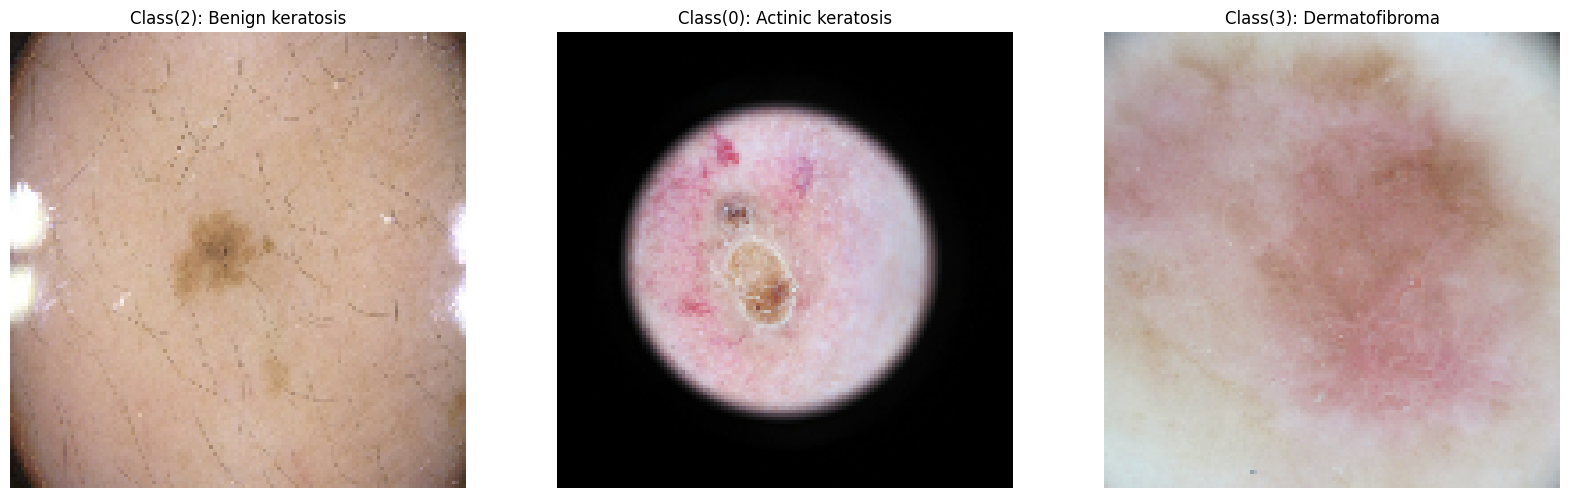

In [10]:
images, labels = batch

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

for i in range(3):
    image = images[i].astype("uint8")
    index = np.argmax(labels[i])
    label = class_names[index]

    axes[i].imshow(image)
    axes[i].set_title(f"Class({index}): {label}", fontsize=12)
    axes[i].axis("off")

plt.show()

## Scale/Normalize data

In [11]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = train_data.map(normalize)
val_data = val_data.map(normalize)
test_data = test_data.map(normalize)

In [12]:
for images, labels in train_data.take(1):
    print("Normalized Images:", images.numpy())
    print("Labels:", labels.numpy()) 
    break 

Normalized Images: [[[[8.89185071e-01 6.10140920e-01 6.05055153e-01]
   [8.83609056e-01 6.00061297e-01 5.92800260e-01]
   [8.27696085e-01 5.58088243e-01 5.21415412e-01]
   ...
   [9.18535531e-01 6.63020849e-01 5.96201003e-01]
   [9.32781875e-01 7.15318620e-01 6.45894587e-01]
   [9.48008597e-01 7.04411745e-01 6.79718137e-01]]

  [[9.08517182e-01 5.97855389e-01 5.49264729e-01]
   [9.02175248e-01 5.89552701e-01 5.61029434e-01]
   [8.93259823e-01 5.88694870e-01 5.30759811e-01]
   ...
   [8.80147040e-01 5.68137228e-01 4.66207117e-01]
   [9.70802724e-01 6.84957087e-01 6.17218137e-01]
   [9.64276969e-01 6.99142158e-01 6.58639729e-01]]

  [[9.04932618e-01 5.78492641e-01 5.47120094e-01]
   [8.94944847e-01 5.66605389e-01 5.20557582e-01]
   [8.89307618e-01 5.67738950e-01 5.16758561e-01]
   ...
   [6.68259799e-01 3.70220602e-01 3.26960772e-01]
   [9.75520849e-01 6.83425248e-01 6.31495118e-01]
   [9.55913007e-01 7.03921556e-01 6.13848031e-01]]

  ...

  [[9.13602948e-01 5.73437512e-01 5.28216898e-0

## Using custom CNN for training

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [102]:
model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(16, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [103]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [104]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,688 (483.16 KB)

 Trainable params: 123,208 (481.28 KB)

 Non-trainable params: 480 (1.88 KB)

In [106]:
epochs = 150

history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=epochs
                   )  

Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.1957 - loss: 2.0475 - precision: 0.2171 - recall: 0.0124 - val_accuracy: 0.1546 - val_loss: 2.0760 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.2103 - loss: 2.0204 - precision: 0.3604 - recall: 0.0177 - val_accuracy: 0.1663 - val_loss: 2.0612 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.2155 - loss: 1.9983 - precision: 0.4182 - recall: 0.0180 - val_accuracy: 0.1639 - val_loss: 2.0492 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2493 - loss: 1.9351 - precision: 0.4473 - recall: 0.0205 - val_accuracy: 0.2084 - val_loss: 1.9762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.2292 - loss: 1.9431 - precision: 0.4675 - recall: 0.0275 - va

In [51]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    plt.figure(figsize=(12, 5))

    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

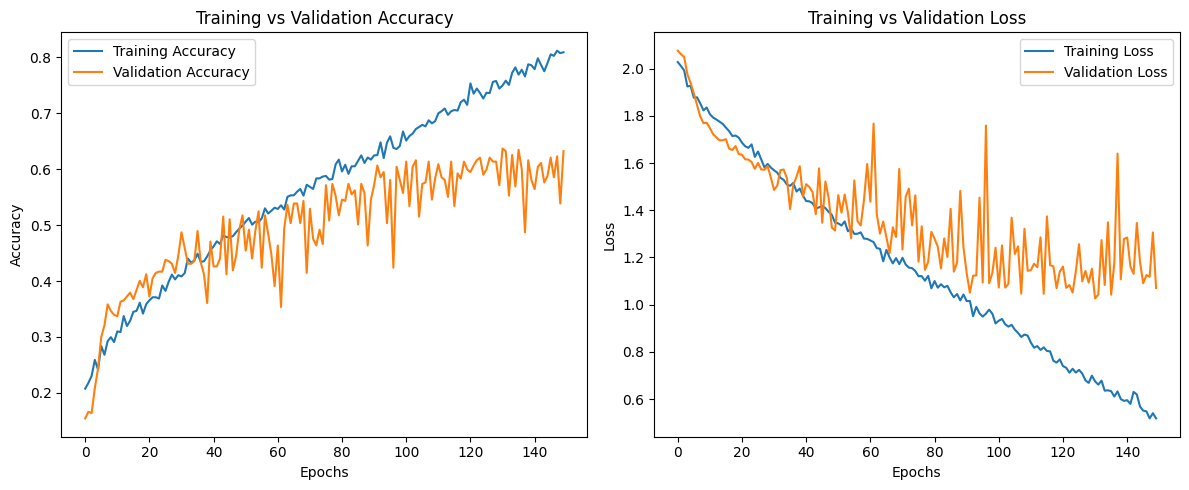

In [107]:
plot_training_history(history)

In [111]:
res = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7500 - loss: 0.5740 - precision: 0.8148 - recall: 0.6875


In [88]:
def evaluate_images(model, test_dataset, num_images=5):
    for batch in test_dataset.take(1):
        images, labels = batch 
        break

    for i in range(min(num_images, images.shape[0])):
        image = images[i]
        true_label = labels[i]
        
        if len(true_label.shape) > 0 and true_label.shape[0] > 1:
            true_label_val = np.argmax(true_label)
        else:
            true_label_val = int(true_label)
        
        img_batch = tf.expand_dims(image, axis=0)
        
        pred = model.predict(img_batch)
        
        pred_label = np.argmax(pred, axis=1)[0]
        
        is_correct = (pred_label == true_label_val)
        print(f"Image {i}: \nTrue Label = {true_label_val}\nPredicted Label = {pred_label}\nCorrect = {is_correct}\n\n")

In [110]:
evaluate_images(model, test_data, num_images=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 0: 
True Label = 4
Predicted Label = 4
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 1: 
True Label = 5
Predicted Label = 4
Correct = False


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 2: 
True Label = 1
Predicted Label = 1
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 3: 
True Label = 0
Predicted Label = 0
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 4: 
True Label = 6
Predicted Label = 6
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 5: 
True Label = 5
Predicted Label = 5
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 6: 
True Label = 1
Predicted Label = 6
Correct = False


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 7: 
True Label = 6
Predicted Label = 6
Correct = True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 8: 
True Label = 3
Predicted Label = 2
Correct = False


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 9: 
True Label = 2
Predicted Label = 2
Correct = True

In [114]:
from IPython.display import FileLink
model.save('/kaggle/working/skin_disease_model_v1.h5')
FileLink('/kaggle/working/skin_disease_model_v1.h5')

/kaggle/working/skin_disease_model_v1.h5